```
convert train.csv to a format suitable for inference
```

In [1]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
from fastai.basics           import *
from fastai.callback.all     import *
from fastai.distributed      import *
from fastai.tabular.all      import *

import ast
import enum
import gc
import pandas as pd
import pickle
import enum

from collections import defaultdict
from fastcore.script import *
from matplotlib import pyplot as plt
from pathlib import Path
from scipy.sparse import coo_matrix, dok_matrix, lil_matrix, csr_matrix, bsr_matrix
from sklearn.metrics import roc_auc_score
from torch.distributions.beta import Beta
from torch.utils.data import Dataset
from tqdm import tqdm

In [3]:
in_d = Path('input')

In [4]:
MAX_USERS = 450000     # estimate users (train + test)
MAX_QUESTIONS = 13523  # num of different question_id

In [5]:
_H = AttrDict
H = _H(
    seed = 0,
    data = '210101b',  # data version
    valid_pct = 0.025,
)

In [6]:
with open(in_d / f'meta_v{H.data}.pkl', 'rb') as f:
    meta = pickle.load(f)

QCols = enum.IntEnum('QCols', meta.qcols, start=0)
LCols = enum.IntEnum('LCols', meta.lcols, start=0)
Cats  = enum.IntEnum('Cats',  meta.cat_names, start=0)
Conts = enum.IntEnum('Conts', meta.cont_names, start=0)

# Seed np

In [7]:
np.random.seed(H.seed)

# Read df

In [8]:
%%time

interaction_dtypes = {
    'row_id': 'int32',
    'timestamp': 'int64',
    'user_id': 'int32',
    'content_id': 'int16',
    'content_type_id': 'int8',
    'task_container_id': 'int16',
    'user_answer': 'int8',
    'answered_correctly': 'int8',
    'prior_question_elapsed_time': 'float32',
    'prior_question_had_explanation': 'boolean'
}

i_df = pd.read_csv(
    in_d / 'train.csv', 
    usecols=interaction_dtypes.keys(),
    dtype=interaction_dtypes,
    #nrows=10**6,
)

CPU times: user 1min 41s, sys: 6.18 s, total: 1min 47s
Wall time: 2min 39s


In [9]:
group_keys = sorted(i_df.user_id.unique())

In [10]:
# Last H.valid_pct is valid set
train_group_keys = group_keys[:int((1 - H.valid_pct) * len(group_keys))]
valid_group_keys = group_keys[int((1 - H.valid_pct) * len(group_keys)):]

In [11]:
print(f'users: train={len(train_group_keys)}, valid={len(valid_group_keys)}')

users: train=383814, valid=9842


In [12]:
df = i_df[i_df.user_id.isin(valid_group_keys)]

In [13]:
assert len(valid_group_keys) == len(df.user_id.unique())

In [14]:
stat = df.groupby('user_id').agg({'timestamp': [np.min, np.max, len]})

In [15]:
max_ts = df.timestamp.max()

<AxesSubplot:>

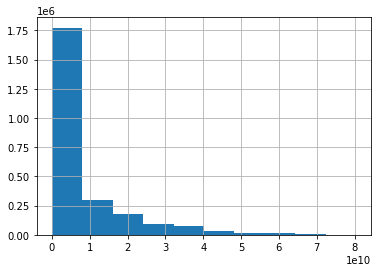

In [16]:
df.timestamp.hist()

In [17]:
stat.sort_values(('timestamp',  'len'))

timestamp                    
                amin         amax    len
user_id                                 
2103184240         0            0      1
2119645200         0            0      1
2131395801         0        13505      2
2110895344         0        48148      3
2136438753         0        50786      3
...              ...          ...    ...
2132723519         0  31428794904  14134
2108652072         0  41660462796  14664
2138700404         0   9084717528  14738
2139561972         0  37057735124  15761
2146130037         0  20136693150  16384

[9842 rows x 3 columns]

# Build test csv data

In [18]:
#df[df.user_id == 1957824471][-100:]

In [19]:
pd.set_option('display.max_rows', 500)

In [20]:
df = df.sort_values(['timestamp', 'row_id'])

In [21]:
idx = df.groupby(['user_id', 'timestamp']).head(1).index

In [22]:
df['group_num'] = 0

In [23]:
df.loc[idx, 'group_num'] = 1

In [24]:
df.group_num = df.groupby('user_id').group_num.transform(lambda x: np.cumsum(x) - 1)

In [25]:
max_gn = df.group_num.max()
max_gn

9999

In [26]:
def random_shift_ts(g):
    return g.timestamp + np.random.randint(0, max_gn - g.group_num.max() + 1)

In [27]:
df.group_num = df.groupby('user_id').group_num.transform(lambda x: x + np.random.randint(0, max_gn - x.max() + 1))

<AxesSubplot:>

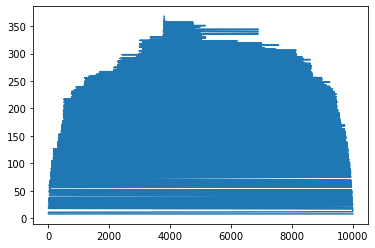

In [28]:
df.group_num.value_counts().plot()

In [29]:
df = df.sort_values(['group_num', 'row_id'])

In [30]:
gac = df.groupby('group_num').answered_correctly.apply(list)

In [31]:
gr = df.groupby('group_num').user_answer.apply(list)

In [32]:
idx = df.groupby('group_num').head(1).index

In [33]:
df.loc[idx[0],  'prior_group_answers_correct'] = '[]'
df.loc[idx[1:], 'prior_group_answers_correct'] = gac[:-1].values

In [34]:
df.loc[idx[0],  'prior_group_responses'] = '[]'
df.loc[idx[1:], 'prior_group_responses'] = gr[:-1].values

In [35]:
df[df.group_num == 0]

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,group_num,prior_group_answers_correct,prior_group_responses
98894519,98894519,0,2097931616,7900,0,0,0,1,NaN,<NA>,0,[],[]
100441978,100441978,0,2132723519,7900,0,0,0,1,NaN,<NA>,0,NaN,NaN
100728469,100728469,0,2138700404,7217,0,0,1,0,20750.0,True,0,NaN,NaN
100728470,100728470,0,2138700404,7219,0,0,0,0,20750.0,True,0,NaN,NaN
100728471,100728471,0,2138700404,7216,0,0,3,1,20750.0,True,0,NaN,NaN
100728472,100728472,0,2138700404,7218,0,0,0,0,20750.0,True,0,NaN,NaN
100781730,100781730,0,2139561972,7900,0,0,0,1,NaN,<NA>,0,NaN,NaN
101149312,101149312,0,2146130037,5080,0,0,0,1,NaN,<NA>,0,NaN,NaN


In [36]:
df[df.group_num == 1]

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,group_num,prior_group_answers_correct,prior_group_responses
98894520,98894520,24510,2097931616,7876,0,1,2,0,22000.0,False,1,"[1, 1, 0, 0, 1, 0, 1, 1]","[0, 0, 1, 0, 3, 0, 0, 0]"
99372835,99372835,0,2108652072,5692,0,0,3,1,NaN,<NA>,1,NaN,NaN
99990208,99990208,0,2122056942,6397,0,0,1,1,NaN,<NA>,1,NaN,NaN
100441979,100441979,29235,2132723519,7876,0,1,0,0,22000.0,False,1,NaN,NaN
100728473,100728473,100619,2138700404,6909,0,1,0,1,20750.0,True,1,NaN,NaN
100728474,100728474,100619,2138700404,6911,0,1,1,0,20750.0,True,1,NaN,NaN
100728475,100728475,100619,2138700404,6910,0,1,3,1,20750.0,True,1,NaN,NaN
100728476,100728476,100619,2138700404,6908,0,1,0,1,20750.0,True,1,NaN,NaN
100781731,100781731,20775,2139561972,7876,0,1,3,1,33000.0,False,1,NaN,NaN
101149313,101149313,17424,2146130037,4665,0,1,2,1,3000.0,False,1,NaN,NaN


In [37]:
df[-100:]

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,group_num,prior_group_answers_correct,prior_group_responses
100743186,100743186,9084494908,2138700404,6777,0,9994,0,1,33750.0,True,9993,NaN,NaN
100797475,100797475,36900761946,2139561972,7540,0,9993,3,1,20200.0,True,9993,NaN,NaN
100797476,100797476,36900761946,2139561972,7539,0,9993,3,1,20200.0,True,9993,NaN,NaN
100912881,100912881,189816,2142086663,6370,0,13,3,0,2000.0,False,9993,NaN,NaN
101165687,101165687,19114958603,2146130037,5126,0,9997,1,1,21000.0,True,9993,NaN,NaN
99069474,99069474,64067483827,2101866594,2032,0,9994,1,1,27333.0,True,9994,"[1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1]","[3, 3, 2, 0, 2, 0, 0, 3, 1, 3, 2, 3, 0, 3, 3, 3, 1]"
99069475,99069475,64067483827,2101866594,2030,0,9994,0,1,27333.0,True,9994,NaN,NaN
99069476,99069476,64067483827,2101866594,2031,0,9994,2,1,27333.0,True,9994,NaN,NaN
99387496,99387496,41574673150,2108652072,5013,0,9997,0,1,19000.0,True,9994,NaN,NaN
99934958,99934958,341231765,2120821070,8002,0,83,1,1,45000.0,True,9994,NaN,NaN


## Test csv

In [38]:
test_cols = ('row_id,group_num,timestamp,user_id,content_id,content_type_id,task_container_id,'
    'prior_question_elapsed_time,prior_question_had_explanation,prior_group_answers_correct,'
    'prior_group_responses'.split(','))
test_cols

['row_id',
 'group_num',
 'timestamp',
 'user_id',
 'content_id',
 'content_type_id',
 'task_container_id',
 'prior_question_elapsed_time',
 'prior_question_had_explanation',
 'prior_group_answers_correct',
 'prior_group_responses']

In [39]:
df_test = df[test_cols]
df_test[:100]

,row_id,group_num,timestamp,user_id,content_id,content_type_id,task_container_id,prior_question_elapsed_time,prior_question_had_explanation,prior_group_answers_correct,prior_group_responses
98894519,98894519,0,0,2097931616,7900,0,0,NaN,<NA>,[],[]
100441978,100441978,0,0,2132723519,7900,0,0,NaN,<NA>,NaN,NaN
100728469,100728469,0,0,2138700404,7217,0,0,20750.0,True,NaN,NaN
100728470,100728470,0,0,2138700404,7219,0,0,20750.0,True,NaN,NaN
100728471,100728471,0,0,2138700404,7216,0,0,20750.0,True,NaN,NaN
100728472,100728472,0,0,2138700404,7218,0,0,20750.0,True,NaN,NaN
100781730,100781730,0,0,2139561972,7900,0,0,NaN,<NA>,NaN,NaN
101149312,101149312,0,0,2146130037,5080,0,0,NaN,<NA>,NaN,NaN
98894520,98894520,1,24510,2097931616,7876,0,1,22000.0,False,"[1, 1, 0, 0, 1, 0, 1, 1]","[0, 0, 1, 0, 3, 0, 0, 0]"
99372835,99372835,1,0,2108652072,5692,0,0,NaN,<NA>,NaN,NaN


In [40]:
df_test.to_csv(in_d / f'validation_x_{H.valid_pct}.csv', index=False)

## Targets csv

In [41]:
target_cols = ['row_id', 'answered_correctly', 'group_num']
target_cols

['row_id', 'answered_correctly', 'group_num']

In [42]:
df_target = df[df.answered_correctly != -1][target_cols]
df_target

,row_id,answered_correctly,group_num
98894519,98894519,1,0
100441978,100441978,1,0
100728469,100728469,0,0
100728470,100728470,0,0
100728471,100728471,1,0
...,...,...,...
100456109,100456109,1,9999
100456110,100456110,1,9999
100456111,100456111,1,9999
100797490,100797490,1,9999


In [43]:
df_target.to_csv(in_d / f'validation_y_{H.valid_pct}.csv', index=False)

## Submission csv

In [44]:
df_target.answered_correctly = 0.5

In [45]:
df_target.to_csv(in_d / f'validation_submission_{H.valid_pct}.csv', index=False)